# Advanced Profile Creation
Creates profiles from parallel lines created in `parallel_transit_lines-Dev` notebook and a digital elevation model. Extends the profile creation from `basic_profile_creation-Dev` to include the transportation route and the location of the NHD streamline.

Assumes transportation routes, from the National Transportation Dataset, align well with elevation data, from the Best Available Topographic dataset.

### Author
John Wall (jwall@Dewberry.com)

### Import libraries

In [42]:
# Sci Stack
import pandas as pd
from matplotlib import pyplot as plt

# GeoSpatial Stack
import geopandas as gpd

import shapely
from shapely import geometry, ops
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats, point_query

### Load data

In [43]:
streams = "/mnt/c/gis/fcast_data/sample_streams.shp"
roads = "/mnt/c/gis/fcast_data/sample_roads.shp"
dem = "/mnt/c/gis/fcast_data/tiffs/c67567_aoi.tif"

### Create parallel lines from transportation routes

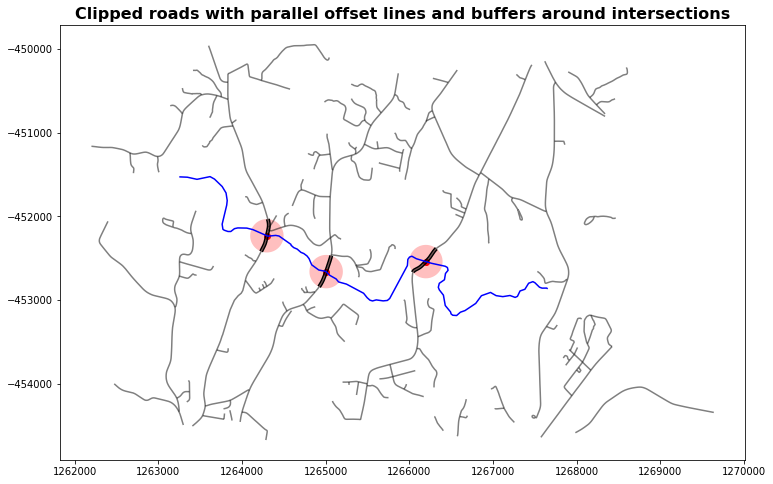

In [44]:
# Set variables based on GIS
# Offsets: Bess (45), Cos (14), Pue (10)
buffer_dist = 200
offset_dist = 15
our_prj = {'proj': 'aea', 'lat_1': 20, 'lat_2': 60, 'lat_0': 40,
             'lon_0': -96, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80',
             'units': 'm', 'no_defs': True}

# Code to execute
stream_prj = gpd.read_file(streams).to_crs(our_prj)
gdf_roads = gpd.read_file(roads).to_crs(our_prj)

# stream_prj = gdf_streams.to_crs(our_prj)
stream_shape = list(stream_prj.geometry)[0]
gdf_roads_diss = gdf_roads.dissolve(by='FULL_STREE')

intersecting_roads = gdf_roads_diss[gdf_roads_diss.geometry.apply(lambda row: stream_shape.intersects(row))].copy()
intersections = intersecting_roads.geometry.apply(lambda row: stream_shape.intersection(row))
intersection_buffers = intersections.buffer(buffer_dist)

clipped_roads = intersection_buffers.intersection(intersecting_roads)

single_lines = {}
for i, road in enumerate(clipped_roads):
    if type(road) is shapely.geometry.multilinestring.MultiLineString:
        single_lines[clipped_roads.index[i]] = ops.linemerge(road)
    else:
        single_lines[clipped_roads.index[i]] = road

# Resulting dictionary needs to be exploded due to roads with same
#     name. For example, if the road is an interstate.
explode_lines = gpd.GeoDataFrame(single_lines.items(), columns=['road','geometry'])
explode_lines = explode_lines.explode().droplevel(0).reset_index(0, drop=True)

# Possibly suboptimal method to create left and right offsets
df_list = []
for side in ['left', 'right']:
    explode_lines['side'] = side
    explode_lines['offset'] = explode_lines.geometry.apply(lambda road: road.parallel_offset(offset_dist, side, resolution=1))
    df_list.append(explode_lines.copy())
offset = pd.concat(df_list).reset_index(0, drop=True)

# Carry out some organization
offset['geometry'] = offset['offset']
offset.drop(columns=['offset'], inplace=True)

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
offset.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream_prj.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines and buffers around intersections", fontsize=16, fontweight='bold');

In [45]:
def multi_to_single_lines(input_lines:gpd.geoseries.GeoSeries, column_name:str) -> gpd.geodataframe.GeoDataFrame:
    """Ensures all lines are single part linestrings"""
    single_lines = {}
    for i, line in enumerate(input_lines):
        if type(line) is shapely.geometry.multilinestring.MultiLineString:
            single_lines[input_lines.index[i]] = ops.linemerge(line)
        else:
            single_lines[input_lines.index[i]] = line
    
    out_gdf = gpd.GeoDataFrame(single_lines.items(), columns=[column_name ,'geometry'])
    
    return out_gdf

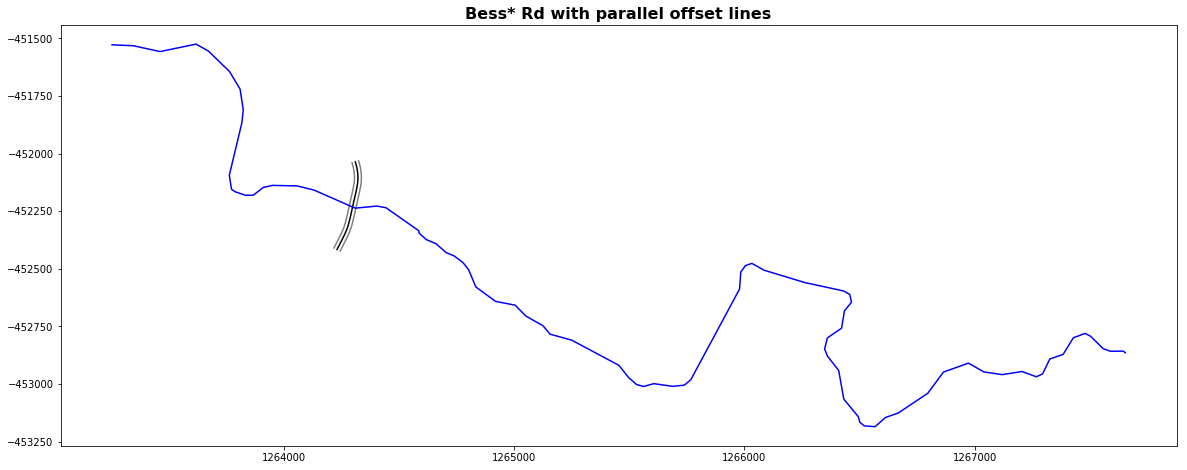

In [46]:
# Set variables
rough_name = 'Bess'
new_column_name = 'road'

# Usure all roads are single lines and select out the Bess* one
single_line_gdf = multi_to_single_lines(clipped_roads, new_column_name)
single_road = single_line_gdf[single_line_gdf[new_column_name].str.contains(rough_name)]
offset_lines = offset[offset['road'].str.contains(rough_name)]

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
single_road.plot(color='k', ax=ax);
offset_lines.plot(color='k', alpha=0.5, ax=ax); # Inline sampling
stream_prj.plot(color='b', ax=ax);
ax.set_title("{}* Rd with parallel offset lines".format(rough_name),
             fontsize=16, fontweight='bold');

In [47]:
def get_topo_from_line(line:str, dem:str) -> pd.core.frame.DataFrame:
    """Identifies the elevation of a point from a shapely linestring from
        a digital elevation model.
    """
    profile = point_query(line, dem)

    vertecies = [Point(coord) for coord in line.coords]
    df = pd.DataFrame(vertecies, columns=['point'])
    df['elev'] = profile[0]
    df['lat'] = df.point.apply(lambda point: point.y)
    
    return df

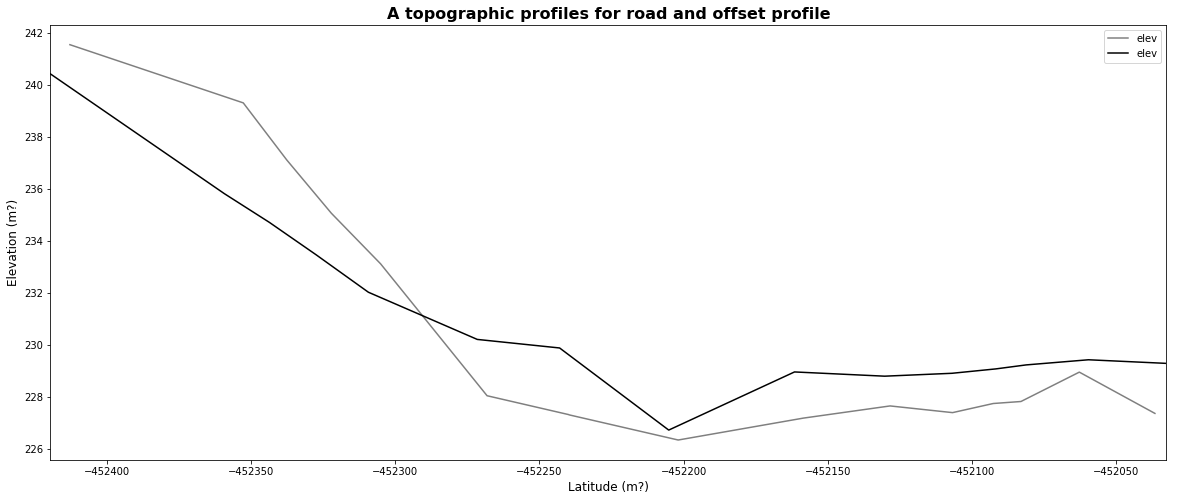

In [48]:
# Grab topographic data along lines
road_profile = get_topo_from_line(list(single_road.geometry)[0], dem)
left_offset_profile = get_topo_from_line(list(offset_lines.geometry)[0], dem)

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='lat',y='elev', color='k', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for road and offset profile", fontsize=16, fontweight='bold');

In [49]:
# Outline basic workflow for choosing lats vs lons
def plot_lat_or_long(df:pd.core.frame.DataFrame, threshold:int) -> None:
    """Basic logic to determine if lats or lons should be plotted"""
    lats = [point.y for point in road_profile.point]
    delta_lat = max(lats) - min(lats)
    if delta_lat >= threshold:
        print("Use lats")
    else:
        print("Use lons")
        
plot_lat_or_long(road_profile, 100)

Use lats


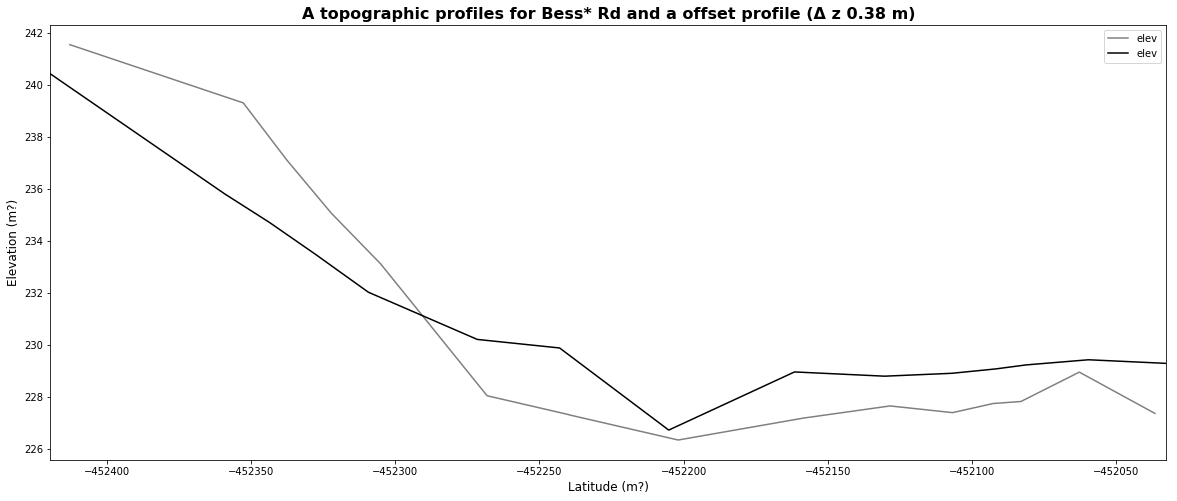

In [50]:
# Get the delta-elevation and report that for the profile
offset_min = min(left_offset_profile.elev)
road_min = min(road_profile.elev)
delta_z = round(road_min - offset_min, 2)

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='lat',y='elev', color='k', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for Bess* Rd and a offset profile (\u0394 z {} m)".format(delta_z),
             fontsize=16, fontweight='bold');

In [51]:
# Set variables
window_size = 3
delta_threshold = 2

# Use a rolling median filter for every three points
road_profile['median'] = road_profile.elev.rolling(window_size).median()

# Drop NaNs and deltas above threshold
road_profile.dropna(inplace=True)
road_profile['z_delta'] = abs(road_profile['median'] - road_profile['elev'])
road_profile.drop(road_profile[road_profile['z_delta'] > delta_threshold].index, inplace=True)

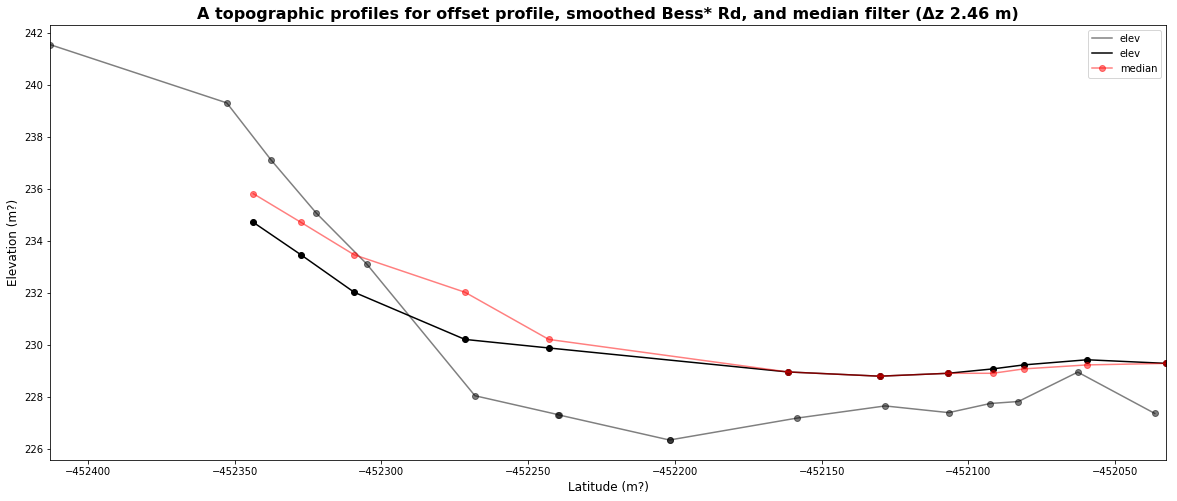

In [52]:
# Recalculated delta-elevation
offset_min = min(left_offset_profile.elev)
road_min = min(road_profile.elev)
delta_z = round(road_min - offset_min, 2)

# Show off results
fig, ax = plt.subplots(figsize = (20,8))

left_offset_profile.plot(x='lat',y='elev', color='k', marker='o', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', marker='o', ax=ax);
road_profile.plot(x='lat',y='median', color='r', alpha=0.5, marker='o', ax=ax);

ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for offset profile, smoothed Bess* Rd, and median filter (\u0394z {} m)".format(delta_z),
             fontsize=16, fontweight='bold');

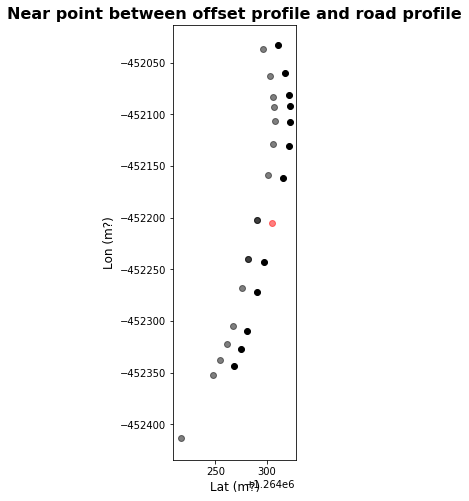

In [53]:
# Pull Pandas DF into GDF, create a linestring
gdf = gpd.GeoDataFrame(road_profile, columns=['point', 'elev', 'lat', 'median', 'z_delta'])
gdf['geometry'] = gdf['point']
string_test = LineString(list(gdf.geometry))

# Identify the minimum point
offset_min = min(left_offset_profile.elev)
minimum = left_offset_profile[left_offset_profile['elev'] == offset_min]
minimum_pnt = list(minimum.point)[0]

# Identify the near point
near_pnts = nearest_points(string_test, minimum_pnt)

# Format the data for plotting
gdf_near = gpd.GeoDataFrame([near_pnts[0]], columns=['geometry'])
gdf_offset = gpd.GeoDataFrame(left_offset_profile)
gdf_offset['geometry'] = gdf_offset['point']

# Show-off results
fig, ax = plt.subplots(figsize = (20,8))
gdf.plot(color='k', marker='o', ax=ax);
gdf_near.plot(color='r', marker='o', alpha=0.5, ax=ax);
gdf_offset.plot(color='k', marker='o', alpha=0.5, ax=ax);

ax.set_ylabel("Lon (m?)", fontsize=12)
ax.set_xlabel("Lat (m?)", fontsize=12)
ax.set_title("Near point between offset profile and road profile",
             fontsize=16, fontweight='bold');

In [59]:
list(near_pnts[0].coords)

[(1264305.1776215509, -452205.15686162823)]

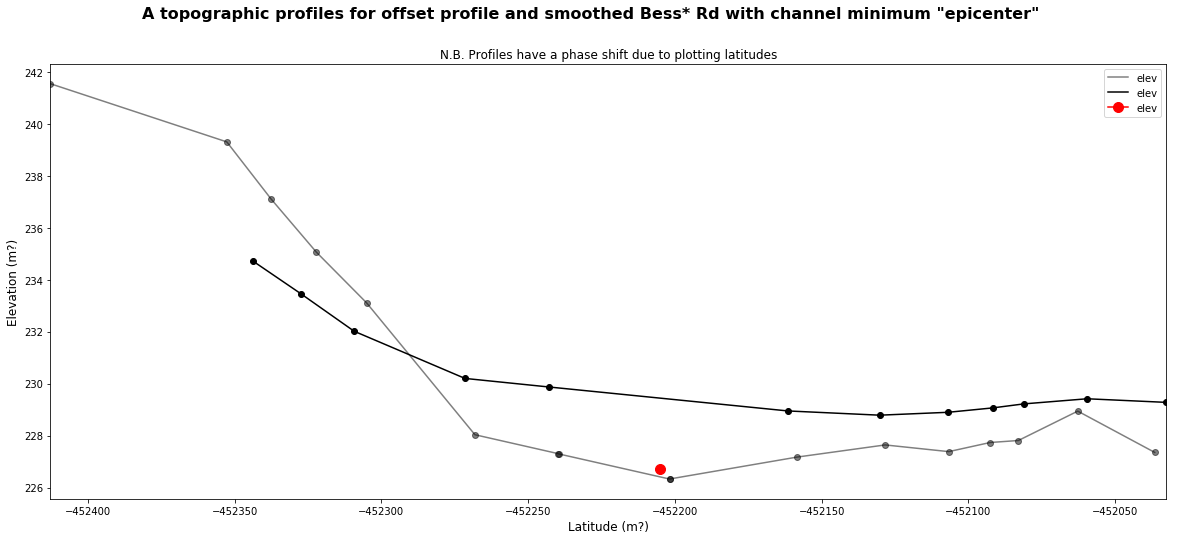

In [54]:
# Obtain the elevation immediately under the near point
#     There are known issues with doing this. For example,
#     if the near point generated is along the line rather
#     than at a vertex and that vertex has been removed
#     due to hydroenforcement.
gdf_near['elev'] = point_query(gdf_near.geometry[0], dem)
gdf_near['lat'] = gdf_near.geometry.apply(lambda point: list(point.coords)[0][1])
df_near = pd.DataFrame(gdf_near)

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='lat',y='elev', color='k', marker='o', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', marker='o', ax=ax);
df_near.plot(x='lat',y='elev', color='r', marker='o', markersize=10, ax=ax);

ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("N.B. Profiles have a phase shift due to plotting latitudes");
fig.suptitle("A topographic profiles for offset profile and smoothed Bess* Rd with channel minimum \"epicenter\"",
                 fontsize=16, fontweight='bold');

In [55]:
# Elevation above needs to be set by interpolated line not the DEM below.

,geometry,elev,lat
0,POINT (1264305.177621551 -452205.1568616282),226.708513,-452205.156862
